In [1]:
import io 
import pandas as pd
from sentence_transformers import SentenceTransformer
from sentence_transformers import models
import numpy as np
from gensim.models import KeyedVectors
import spacy
import re
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import cosine_similarity
import itertools

#nlp = spacy.load("en_core_web_sm")

model = KeyedVectors.load_word2vec_format("/home/adrian/PhD/Data/Word2Vec/BioASQvectors2018/pubmed2018_w2v_200D/pubmed2018_w2v_200D.bin", binary=True)


#df2 = pd.read_csv(io.BytesIO(uploaded['file_name.csv'])) 
df = pd.read_parquet('/home/adrian/PhD/Data/Pubmed/baseline_diabetes_unique.parquet')
df.head() 

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


,title,abstract,date,mesh_ui,mesh_mh,mesh_ui_diab,mesh_mh_diab,title_abstract_prep
PMID,,,,,,,,
29913182,The genetic architecture of type 1 diabetes me...,Type 1 diabetes mellitus (T1D) is a complex au...,2018-12-05,"D015551,D003922,D020022,D014644,D055106,D00668...","Autoimmunity,Diabetes Mellitus, Type 1,Genetic...",D003922,"Diabetes Mellitus, Type 1",the genetic architecture of type 1 diabetes me...
29913317,Evaluation of knowledge regarding gestational ...,OBJECTIVE\nThe aim of this study was to evalua...,2018-08,"D000293,D000328,D000368,D000369,D001459,D00343...","Adolescent,Adult,Aged,Aged, 80 and over,Bangla...",D016640,"Diabetes, Gestational",evaluation of knowledge regarding gestational ...
29913486,Prognostic Implications of Single-Sample Confi...,Background\nCurrent clinical definitions of di...,2018-08-07,"D001786,D003920,D005260,D006442,D006801,D00829...","Blood Glucose,Diabetes Mellitus,Female,Glycate...",D003920,Diabetes Mellitus,prognostic implications of single-sample confi...
29914063,Traditional Chinese Medical Care and Incidence...,OBJECTIVES\nExperimental research has shown th...,2018-06-15,"D000368,D000369,D003924,D004365,D005260,D00550...","Aged,Aged, 80 and over,Diabetes Mellitus, Type...",D003924,"Diabetes Mellitus, Type 2",traditional chinese medical care and incidence...
29914066,Connexin 43-Based Therapeutics for Dermal Woun...,The most ubiquitous gap junction protein withi...,2018-06-15,"D000818,D002921,D018031,D017719,D006801,D01044...","Animals,Cicatrix,Connexin 43,Diabetic Foot,Hum...",D017719,Diabetic Foot,connexin 43-based therapeutics for dermal woun...


In [2]:
import re
import math

index2word_set = set(model.wv.index2word)

def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

def avg_feature_vector(sentence, model=model, num_features=200, index2word_set=index2word_set):
    #words = sentence.split()
    try:
        words = bioclean(sentence)
    except:
        print("bioclean did not work for: {}".format(sentence))
        print(type(sentence))
        print(math.isnan(sentence))
    feature_vec = np.zeros((num_features, ), dtype='float32')
    n_words = 0
    for word in words:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model[word])
        else:
            if hasNumbers(word):
                print("word not in vocabulary: {}".format(word))
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec


# clean for BioASQ
bioclean = lambda t: re.sub('[.,?;*!%^&_+():-\[\]{}]', '', t.replace('"', '').replace('/', '').replace('\\', '').replace("'",'').strip().lower()).split()

# TODO: check if removing stopwords ? 

#df_vec = (df.title + " " + df.abstract).map(lambda abstract: avg_feature_vector(abstract))
#df_vec = np.stack(df_vec.values, axis = 0)

#print(df_vec.shape)


/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.


In [6]:
ll = ["diabetes insulin is a great glucose study",
      "two apples are better than four",
     "a diabetes study can be very boring great"
     , "the weather today is rainy sadly"
     , "insulin diabetes glucose"]

df_vec = pd.Series(ll).map(lambda abstract: avg_feature_vector(abstract))
df_vec = np.stack(df_vec.values, axis = 0)
HC = AgglomerativeClustering(n_clusters=4, affinity="cosine", linkage="average")
HC.fit(df_vec)

print("Number of leaves: {}".format(HC.n_leaves_))
print("Number of clusters: {}".format(HC.n_clusters_))
print(HC.labels_)
print("Tree:")
# https://stackoverflow.com/questions/27386641/how-to-traverse-a-tree-from-sklearn-agglomerativeclustering
ii = itertools.count(df_vec.shape[0])
tree = [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in HC.children_]
#print(tree)

similarity = 1-cosine_similarity(df_vec)
HC2 = AgglomerativeClustering(n_clusters=4, affinity="precomputed", linkage="average")
HC2.fit(similarity)

print("Number of leaves: {}".format(HC2.n_leaves_))
print("Number of clusters: {}".format(HC2.n_clusters_))
print(HC2.labels_)

Number of leaves: 5
Number of clusters: 4
[0 2 0 3 1]
Tree:
Number of leaves: 5
Number of clusters: 4
[0 2 0 3 1]


In [15]:
similarity = 1-cosine_similarity(df_vec)
HC2 = AgglomerativeClustering(n_clusters=6, affinity="precomputed", linkage="average")
HC2.fit(similarity)
print("Number of leaves: {}".format(HC2.n_leaves_))
print("Number of clusters: {}".format(HC2.n_clusters_))
print(HC2.labels_)


Number of leaves: 30
Number of clusters: 6
[0 0 4 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 5 2 0]


In [14]:
#similarity = cosine_similarity(df_vec)
similarity = df_vec
print(similarity.shape)
HC = AgglomerativeClustering(n_clusters=6, affinity="cosine", linkage="average")
HC.fit(similarity)

print("Number of leaves: {}".format(HC.n_leaves_))
print("Number of clusters: {}".format(HC.n_clusters_))

# https://stackoverflow.com/questions/27386641/how-to-traverse-a-tree-from-sklearn-agglomerativeclustering
ii = itertools.count(df_vec.shape[0])
tree = [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in HC.children_]
print(HC.labels_)
tree#[0:5]



(30, 200)
Number of leaves: 30
Number of clusters: 6
[0 2 2 2 5 1 0 0 0 2 0 2 0 2 2 1 0 0 2 2 2 2 2 4 3 0 0 2 2 2]


[{'node_id': 30, 'left': 6, 'right': 26},
 {'node_id': 31, 'left': 21, 'right': 27},
 {'node_id': 32, 'left': 3, 'right': 11},
 {'node_id': 33, 'left': 19, 'right': 22},
 {'node_id': 34, 'left': 2, 'right': 31},
 {'node_id': 35, 'left': 20, 'right': 32},
 {'node_id': 36, 'left': 7, 'right': 17},
 {'node_id': 37, 'left': 9, 'right': 35},
 {'node_id': 38, 'left': 0, 'right': 30},
 {'node_id': 39, 'left': 29, 'right': 34},
 {'node_id': 40, 'left': 8, 'right': 10},
 {'node_id': 41, 'left': 1, 'right': 14},
 {'node_id': 42, 'left': 28, 'right': 33},
 {'node_id': 43, 'left': 37, 'right': 41},
 {'node_id': 44, 'left': 18, 'right': 42},
 {'node_id': 45, 'left': 39, 'right': 43},
 {'node_id': 46, 'left': 38, 'right': 40},
 {'node_id': 47, 'left': 16, 'right': 36},
 {'node_id': 48, 'left': 12, 'right': 25},
 {'node_id': 49, 'left': 5, 'right': 15},
 {'node_id': 50, 'left': 13, 'right': 44},
 {'node_id': 51, 'left': 45, 'right': 50},
 {'node_id': 52, 'left': 46, 'right': 47},
 {'node_id': 53, 'le

In [4]:
df["class_predict"] = HC.labels_
tree_df = pd.DataFrame(tree, columns=["node_id", "left", "right"])
tree_df.head()

,node_id,left,right
0,30,6,26
1,31,21,27
2,32,3,11
3,33,19,22
4,34,2,31


In [6]:
df.class_predict.value_counts()

2    15
0    10
1     2
5     1
4     1
3     1
Name: class_predict, dtype: int64

In [5]:
# SAVE TESTS 
df.to_parquet("/home/adrian/workspace/Hierarchical-Clustering-Active-Learning-Text/diabetes_abstracts_HC_output_30Examples.parquet")
tree_df.to_parquet("/home/adrian/workspace/Hierarchical-Clustering-Active-Learning-Text/diabetes_abstracts_tree_output_30Examples.parquet")

In [11]:
df.to_parquet("/home/adrian/workspace/Hierarchical-Clustering-Active-Learning-Text/diabetes_abstracts_HC_output.parquet")
tree_df.to_parquet("/home/adrian/workspace/Hierarchical-Clustering-Active-Learning-Text/diabetes_abstracts_tree_output.parquet")

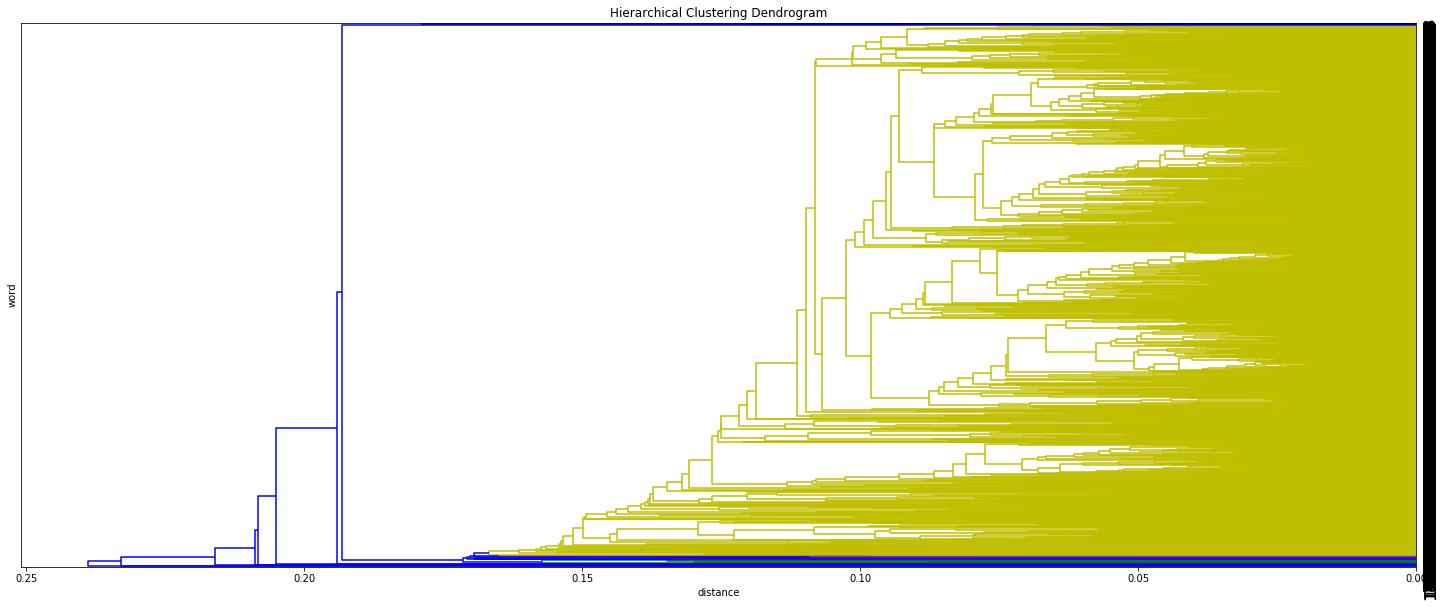

In [29]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

l = linkage(df_vec, method='average', metric='cosine')

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    l,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=16.,  # font size for the x axis labels
    orientation='left',
    #leaf_label_func=lambda v: df.MeshHeading[v]
)
plt.show()

In [38]:
from sklearn import metrics
from collections import Counter

df["predicted"] = HC.labels_

print("ARI score: ", metrics.adjusted_rand_score(pd.factorize(df["MeshHeading"])[0], df["predicted"]))

df.head(20)

ARI score:  0.016638075723298763


,PMID,DateCompleted,Title,Abstract,MeshUI,MeshNumber,MeshHeading,predicted
2,21842608,2011-11-03,Case of distal renal tubular acidosis complica...,We report herein a 27-year-old male case of in...,D048909,C19.246.099,Diabetes Complications,2
10,20500966,2010-07-22,Gestational diabetes insipidus: a review of an...,"To review the etiology, diagnosis, and managem...",D016640,C19.246.200,"Diabetes, Gestational",2
11,23380272,2013-08-26,Gestational diabetes insipidus during a twin p...,Gestational diabetes insipidus is an uncommon ...,D016640,C19.246.200,"Diabetes, Gestational",2
41,25646595,2015-12-17,Transsphenoidal surgery and diabetes mellitus:...,Transsphenoidal surgery (TSS) has emerged as t...,D048909,C19.246.099,Diabetes Complications,2
171,30776978,2019-12-30,Nut Consumption in Relation to Cardiovascular ...,The evidence regarding the potential health be...,D048909,C19.246.099,Diabetes Complications,2
173,30866836,2019-04-26,Prevalence of diabetes mellitus among tubercul...,Tuberculosis and diabetes mellitus are signifi...,D048909,C19.246.099,Diabetes Complications,2
222,30595142,2019-10-18,Gestational diabetes mellitus is associated wi...,"Among singleton pregnancies, gestational diabe...",D016640,C19.246.200,"Diabetes, Gestational",2
258,31110387,2019-12-23,Increased Incidence in False Positive Diagnosi...,"Currently, most of the countries across the gl...",D016640,C19.246.200,"Diabetes, Gestational",2
296,29735392,2019-02-25,Postnatal gestational diabetes mellitus follow...,The reasons for low postnatal screening rates ...,D016640,C19.246.200,"Diabetes, Gestational",2
359,30608180,2019-11-26,Sapropterin Treatment Prevents Congenital Hear...,Background Tetrahydrobiopterin is a cofactor o...,D016640,C19.246.200,"Diabetes, Gestational",5


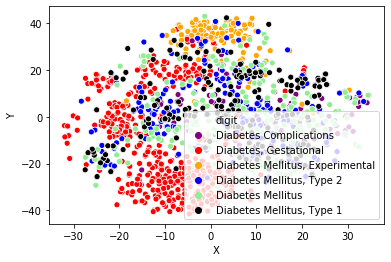

In [33]:
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, random_state=0)
tsne_obj= tsne.fit_transform(df_vec)

tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1],
                        #'digit':HC.labels_ # predicted 
                        "digit" : df["MeshHeading"] # real label
                        
                        
                       })

sns.scatterplot(x="X", y="Y",
              hue="digit",
              palette=['purple','red','orange','blue',
                       'lightgreen', 'black'],
              legend='full',
              data=tsne_df)

In [39]:

with open("/home/adrian/PhD/Data/Word2Vec/pubmed2018_w2v_200D/pubmed2018_w2v_200D.txt", 'w') as f:
    f.write(str(len(model.wv.vocab.keys()))+" "+str(len(model.wv[list(model.wv.vocab.keys())[0]]))+"\n")
    for word in model.wv.vocab.keys():
        f.write(word+" ")
        for value in model.wv[word]: f.write(str(value)+" ")
        f.write("\n")

/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/adrian/miniconda3/envs/deepscience/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


In [43]:
df.Abstract.values[20:50]

array(['A large neck circumference might be an indicator of metabolic syndrome and its components, and for certain patients is more practical as an index than waist circumference. The demarcation value for neck circumference that suggests metabolic syndrome appears to vary by ethnic group. Gestational diabetes mellitus is considered a component of metabolic syndrome in pregnant women. We investigated whether neck circumference in Han Chinese women is associated with gestational diabetes mellitus in early pregnancy, and determined a predictive demarcation value.',
       'Gestational diabetes mellitus, defined as any carbohydrate intolerance first diagnosed during pregnancy, is associated with a variety of adverse outcomes, both for the mother and her child.',
       'Gestational diabetes insipidus (GDI) is a rare disorder characterised by polyuria, polydypsia, and excessive thirst usually manifesting in the third trimester of pregnancy. The etiology is thought to depend on excessive va

### Add vectors to abstracts and export (for use of spark HC)

In [4]:
import pandas as pd
data = pd.read_parquet('/home/adrian/PhD/Data/Pubmed/baseline_diabetes_unique_maxNperClass5000_withoutRootClassDiabetesMellitus.parquet')
data["vec"] = (data.title + " " + data.abstract).map(lambda abstract: avg_feature_vector(abstract))
#data.index = data.index.get_level_values("PMID")
data = data.reset_index(drop=True)
data["PMID"] = pd.to_numeric(data["PMID"])
data.head()

word not in vocabulary: 30-minute-periods
word not in vocabulary: protein-1-s-1
word not in vocabulary: r2963
word not in vocabulary: pgly972arg
word not in vocabulary: 06-646
word not in vocabulary: 3--1738
word not in vocabulary: 2--200
word not in vocabulary: 03-255
word not in vocabulary: 119-1161
word not in vocabulary: 154-382
word not in vocabulary: 143-329
word not in vocabulary: 196-1007
word not in vocabulary: 1038±47
word not in vocabulary: in1-positive
word not in vocabulary: dfra12-orff-aada2-cmia1-aada1-qach-is440-sul3
word not in vocabulary: dfra17-
word not in vocabulary: in2-positive
word not in vocabulary: znt8-a
word not in vocabulary: znt8-a
word not in vocabulary: posm1
word not in vocabulary: posm0
word not in vocabulary: posm1posm0
word not in vocabulary: posm1-posm0
word not in vocabulary: -25780
word not in vocabulary: -37221
word not in vocabulary: 1543334
word not in vocabulary: n4533
word not in vocabulary: ci050-133
word not in vocabulary: ci029-200
word no

word not in vocabulary: n3234
word not in vocabulary: n2886
word not in vocabulary: n5403
word not in vocabulary: 2h-ins
word not in vocabulary: ratio1700
word not in vocabulary: interval1390
word not in vocabulary: ratio2017
word not in vocabulary: interval1671
word not in vocabulary: cia9
word not in vocabulary: cia9
word not in vocabulary: cia9
word not in vocabulary: cia9
word not in vocabulary: 13-butanediol-treated
word not in vocabulary: dr3-dqa105-dqb102
word not in vocabulary: drb104-dqa103-dqb10302
word not in vocabulary: drb111121303-dqa105-dqb10301
word not in vocabulary: drb10110-dqb10501
word not in vocabulary: drb11301-0603
word not in vocabulary: -4260
word not in vocabulary: 22-2h-palmitate
word not in vocabulary: 50-kwapisz
word not in vocabulary: $34146
word not in vocabulary: glycerol-2-palmitoyl-13-di-15-p-iodophenylpentadecanoate
word not in vocabulary: 20071031
word not in vocabulary: aflatoxinb1-exposed
word not in vocabulary: ml·min-1·173m-2
word not in vocabul

word not in vocabulary: 99ctc-dtpa
word not in vocabulary: d8-valine
word not in vocabulary: 65±38
word not in vocabulary: 162±87
word not in vocabulary: 302±133
word not in vocabulary: 614±427
word not in vocabulary: 512±135
word not in vocabulary: 369±075
word not in vocabulary: nct02721888
word not in vocabulary: mt-3995
word not in vocabulary: sc-3150
word not in vocabulary: -scdr1
word not in vocabulary: 3815621
word not in vocabulary: mirabilis-scdr1
word not in vocabulary: 074-09
word not in vocabulary: 836100000
word not in vocabulary: 758-919
word not in vocabulary: 1843-2502
word not in vocabulary: 523-671
word not in vocabulary: 225-267
word not in vocabulary: 234-305kgm2
word not in vocabulary: 91453439
word not in vocabulary: 561064
word not in vocabulary: 332676
word not in vocabulary: 571224
word not in vocabulary: 739974
word not in vocabulary: 1h-magnetic-resonance-spectroscopy
word not in vocabulary: 456±70
word not in vocabulary: 283±48
word not in vocabulary: 447±98

word not in vocabulary: ∼8h
word not in vocabulary: 82±71g
word not in vocabulary: tgf-β1-specific
word not in vocabulary: 033±067
word not in vocabulary: 22heptane-2-carboxylic
word not in vocabulary: 46-1570
word not in vocabulary: 698-738
word not in vocabulary: 43-186
word not in vocabulary: ckip-1-nrf2-are
word not in vocabulary: 08605
word not in vocabulary: 1057647
word not in vocabulary: 083-234
word not in vocabulary: 182-326
word not in vocabulary: 427-146
word not in vocabulary: 855-885
word not in vocabulary: 871411
word not in vocabulary: 774569
word not in vocabulary: 395608
word not in vocabulary: -5722
word not in vocabulary: 924749
word not in vocabulary: 132383
word not in vocabulary: 102482
word not in vocabulary: 689884
word not in vocabulary: 0775-0786
word not in vocabulary: 657-684
word not in vocabulary: nct01788527
word not in vocabulary: increment25
word not in vocabulary: 87·50
word not in vocabulary: 64·58-110·42
word not in vocabulary: 71·43
word not in voc

word not in vocabulary: 300-1800jm2
word not in vocabulary: 600jm2
word not in vocabulary: 242-104
word not in vocabulary: 115--type
word not in vocabulary: 51--decompensated
word not in vocabulary: 529--subclinical
word not in vocabulary: 263-325
word not in vocabulary: 261-330
word not in vocabulary: 035033-038
word not in vocabulary: 043042-045
word not in vocabulary: rg-1-4
word not in vocabulary: $24740
word not in vocabulary: $16579
word not in vocabulary: $18320
word not in vocabulary: pt38-cpi-17
word not in vocabulary: pt853-mypt1
word not in vocabulary: pt696-mypt1
word not in vocabulary: ps19-myl9
word not in vocabulary: phosphatase-1δ
word not in vocabulary: pt853mypt1
word not in vocabulary: pt38cpi-17
word not in vocabulary: pt696mypt1
word not in vocabulary: ps19myl9
word not in vocabulary: pt38cpi-17
word not in vocabulary: ps19myl9
word not in vocabulary: pt853mypt1
word not in vocabulary: pt696mypt1
word not in vocabulary: 1935-43450
word not in vocabulary: 3541-586
w

word not in vocabulary: p53-evoked
word not in vocabulary: p53mirs
word not in vocabulary: 3-methyladenenine
word not in vocabulary: -374at
word not in vocabulary: 50965
word not in vocabulary: 778-97
word not in vocabulary: 1091-298
word not in vocabulary: 431week
word not in vocabulary: 354week
word not in vocabulary: 60596
word not in vocabulary: p-p65nuclear
word not in vocabulary: 5-hydroxytriptamine-induced
word not in vocabulary: shirf8
word not in vocabulary: 601±82
word not in vocabulary: 155±98
word not in vocabulary: subgr2
word not in vocabulary: subgr3
word not in vocabulary: 012-11
word not in vocabulary: 11c3-o-methyl-d-glucose
word not in vocabulary: 11c3-o-methyl-d-glucose
word not in vocabulary: 188-230
word not in vocabulary: 181-241
word not in vocabulary: 171-228
word not in vocabulary: 319-683
word not in vocabulary: -7918
word not in vocabulary: -3993
word not in vocabulary: chictr-icr-15006311
word not in vocabulary: 036-716
word not in vocabulary: 026-162
word 

word not in vocabulary: 4l-8l
word not in vocabulary: 260-1109
word not in vocabulary: 433-2685
word not in vocabulary: 276-6741
word not in vocabulary: 696-7693
word not in vocabulary: 775-5144
word not in vocabulary: 003abstract
word not in vocabulary: 08-024
word not in vocabulary: httplinkslwwcomconha5
word not in vocabulary: mil-1β
word not in vocabulary: mil-8
word not in vocabulary: nct02528344
word not in vocabulary: 11-3547
word not in vocabulary: 362818
word not in vocabulary: rbfox2-mediated
word not in vocabulary: 32142-147
word not in vocabulary: 479160
word not in vocabulary: 449747
word not in vocabulary: 377374
word not in vocabulary: 425-597
word not in vocabulary: ci029-062
word not in vocabulary: ci015-056
word not in vocabulary: 8-year-forgotten
word not in vocabulary: 467922
word not in vocabulary: 588321
word not in vocabulary: 171~329
word not in vocabulary: 305~495
word not in vocabulary: 033~064
word not in vocabulary: 174~316
word not in vocabulary: 0037-002
w

word not in vocabulary: 111in-oxin
word not in vocabulary: 99mtc-111in-human
word not in vocabulary: 161135-223
word not in vocabulary: paco215xhco3-8
word not in vocabulary: tc-co2164xhco3-39
word not in vocabulary: hco3-061xtc-co2-39
word not in vocabulary: rs11977021
word not in vocabulary: -1537ct
word not in vocabulary: 21426ga
word not in vocabulary: 125305
word not in vocabulary: 212705
word not in vocabulary: 125305
word not in vocabulary: 155513
word not in vocabulary: savor-timi53
word not in vocabulary: 3×10cm
word not in vocabulary: vs067±015
word not in vocabulary: 097±02
word not in vocabulary: vs061±024
word not in vocabulary: 074±024
word not in vocabulary: 064±021
word not in vocabulary: 52ms
word not in vocabulary: 63222
word not in vocabulary: mir-126-expressing
word not in vocabulary: 123±041
word not in vocabulary: 162±047
word not in vocabulary: 124±037
word not in vocabulary: 856±084
word not in vocabulary: 139±021
word not in vocabulary: 192±061
word not in voca

word not in vocabulary: actrn12610000681055
word not in vocabulary: age≥20years
word not in vocabulary: n15661
word not in vocabulary: ≥699mmoll
word not in vocabulary: ≥475mmolmol
word not in vocabulary: n4539
word not in vocabulary: 120-876
word not in vocabulary: 276-1353
word not in vocabulary: 146-681
word not in vocabulary: 615-5894
word not in vocabulary: 104-1126
word not in vocabulary: 105786
word not in vocabulary: 958729
word not in vocabulary: immunoglobulinc3
word not in vocabulary: 46684
word not in vocabulary: 107-552
word not in vocabulary: 109-431
word not in vocabulary: httpdeptswashingtonedul2l
word not in vocabulary: mtp23
word not in vocabulary: mtp45
word not in vocabulary: 01-248
word not in vocabulary: 05ci
word not in vocabulary: 714h
word not in vocabulary: 890h
word not in vocabulary: 3493g
word not in vocabulary: 3265g
word not in vocabulary: millimeter3
word not in vocabulary: millimeter3
word not in vocabulary: 35-kcalkg
word not in vocabulary: nct00744965

word not in vocabulary: 20-100ngml
word not in vocabulary: 15-75ngml
word not in vocabulary: hsa-mir-323b-5p
word not in vocabulary: hsa-mir-323b-5p
word not in vocabulary: 87-202
word not in vocabulary: 834±238
word not in vocabulary: 625±109
word not in vocabulary: 302±68
word not in vocabulary: 229±43
word not in vocabulary: 114±62
word not in vocabulary: 160±47
word not in vocabulary: 44254±5616
word not in vocabulary: 40069±4528
word not in vocabulary: gse2956
word not in vocabulary: ages-rage-pkc-β-tgf-β1
word not in vocabulary: nct00279305
word not in vocabulary: 11623-1732
word not in vocabulary: 11804-1828
word not in vocabulary: 1161-102
word not in vocabulary: 1185-152
word not in vocabulary: 969-115
word not in vocabulary: 739-123
word not in vocabulary: 791-869
word not in vocabulary: 357696
word not in vocabulary: 097-391
word not in vocabulary: 160-571
word not in vocabulary: 6-14cglucose-6-phosphate
word not in vocabulary: nct01246765
word not in vocabulary: 389-565
wor

word not in vocabulary: 549±158
word not in vocabulary: 0331±0137
word not in vocabulary: 0340±0140
word not in vocabulary: 1028±0447
word not in vocabulary: 0-502
word not in vocabulary: 147-251
word not in vocabulary: 228-338
word not in vocabulary: 305-343
word not in vocabulary: 172-295
word not in vocabulary: 170-272
word not in vocabulary: p75ntr-promoted
word not in vocabulary: 5-hydroxy-1-
word not in vocabulary: nz-419cr
word not in vocabulary: isshp-2014
word not in vocabulary: isshp-2014
word not in vocabulary: isshp-2014
word not in vocabulary: isshp-2014
word not in vocabulary: bmp7-activated
word not in vocabulary: 151797
word not in vocabulary: 112743
word not in vocabulary: 14371916
word not in vocabulary: 25326722
word not in vocabulary: ebm-ivcrbn1
word not in vocabulary: 37-59ngml
word not in vocabulary: dra10101-drb10401
word not in vocabulary: dq8rip-b7
word not in vocabulary: dr4rip-b7
word not in vocabulary: dq8dr4rip-b7
word not in vocabulary: dr4rip-b7
word not

word not in vocabulary: cromakalim03
word not in vocabulary: n3779
word not in vocabulary: 0678-0682
word not in vocabulary: 0698-0702
word not in vocabulary: 0219-0235
word not in vocabulary: 0738-0742
word not in vocabulary: 0757-0762
word not in vocabulary: 0317-0339
word not in vocabulary: anti-fcεr1-treated
word not in vocabulary: anti-fcεr1-mediated
word not in vocabulary: derivation072
word not in vocabulary: validation071
word not in vocabulary: derivation071
word not in vocabulary: validation070
word not in vocabulary: antithrombotics072
word not in vocabulary: antithrombotics073
word not in vocabulary: approach073
word not in vocabulary: approach068
word not in vocabulary: 14cg6p
word not in vocabulary: nct00573781
word not in vocabulary: 225-27
word not in vocabulary: wok4bb
word not in vocabulary: n-glucitol-glp-1
word not in vocabulary: 1180-3637
word not in vocabulary: 93179
word not in vocabulary: 78021
word not in vocabulary: 3033th
word not in vocabulary: psi-il-10
wor

word not in vocabulary: 8-isoprostane-markers
word not in vocabulary: ci024-080
word not in vocabulary: ci048-096
word not in vocabulary: chictr-prc-06000005
word not in vocabulary: ≈380
word not in vocabulary: δigfbp-1
word not in vocabulary: 1198-199
word not in vocabulary: 100g-3h-ogtt
word not in vocabulary: g-2h-ogtt
word not in vocabulary: 0025-00125
word not in vocabulary: 79879
word not in vocabulary: 515-586
word not in vocabulary: 097161
word not in vocabulary: 116363
word not in vocabulary: 127213
word not in vocabulary: 131-397
word not in vocabulary: egfr-pi3k-akt-creb
word not in vocabulary: 245-687
word not in vocabulary: 252-711
word not in vocabulary: 00774904
word not in vocabulary: md2me
word not in vocabulary: md2me
word not in vocabulary: md2me
word not in vocabulary: md2me
word not in vocabulary: 169-893
word not in vocabulary: 274-826
word not in vocabulary: 319-118
word not in vocabulary: co-transporter2
word not in vocabulary: irs-1growth
word not in vocabulary

word not in vocabulary: 0807-0995
word not in vocabulary: 0973-0986
word not in vocabulary: 71mmoll
word not in vocabulary: 77mmoll
word not in vocabulary: hba1c-or
word not in vocabulary: 1480±212mmhg
word not in vocabulary: 1360±173mmhg
word not in vocabulary: 1383±197mmhg
word not in vocabulary: 415-251
word not in vocabulary: 680-333
word not in vocabulary: 705-357
word not in vocabulary: or6295
word not in vocabulary: 24500mm3
word not in vocabulary: 216000mm3
word not in vocabulary: 136mm3
word not in vocabulary: 60-subject
word not in vocabulary: 8-arm-peg-catecholheparin
word not in vocabulary: 8-arm-peg-catechol
word not in vocabulary: peg8ufh
word not in vocabulary: peg8ufh
word not in vocabulary: peg8ufh
word not in vocabulary: ca-rock1
word not in vocabulary: 070-48
word not in vocabulary: 1a-receptor-deficient
word not in vocabulary: 070065-075
word not in vocabulary: 120107-135
word not in vocabulary: 135126-146
word not in vocabulary: 336292-387
word not in vocabulary: i

word not in vocabulary: leub25-insulin
word not in vocabulary: 95ci18-32
word not in vocabulary: 99-164
word not in vocabulary: 253238
word not in vocabulary: s0h
word not in vocabulary: s0h
word not in vocabulary: s0h
word not in vocabulary: 1149-15933
word not in vocabulary: 1228-6568
word not in vocabulary: 2158-12579
word not in vocabulary: 0095-0424
word not in vocabulary: 40frac67
word not in vocabulary: 41frac67
word not in vocabulary: 40frac67
word not in vocabulary: 41frac67
word not in vocabulary: 579±102years
word not in vocabulary: 181-489
word not in vocabulary: 10-639
word not in vocabulary: 154-10034
word not in vocabulary: 105-492
word not in vocabulary: 102-1448
word not in vocabulary: irct201509115623n52
word not in vocabulary: 44903
word not in vocabulary: than000134576p
word not in vocabulary: 34455p
word not in vocabulary: 32651p
word not in vocabulary: 1033μm
word not in vocabulary: 227-434
word not in vocabulary: g--4a
word not in vocabulary: sham-7
word not in v

word not in vocabulary: 1400000-500000
word not in vocabulary: 55947
word not in vocabulary: nalp3asccaspase-1
word not in vocabulary: nalp3asccaspase-1
word not in vocabulary: 3754-14250
word not in vocabulary: 9750-9790
word not in vocabulary: 9000-9060
word not in vocabulary: sorl1sorlalr11
word not in vocabulary: sorting-10
word not in vocabulary: sorcs1cβ-myc
word not in vocabulary: sorcs1cβ-myc
word not in vocabulary: sorcs1app
word not in vocabulary: sorcs1sorl1
word not in vocabulary: sorcs1vps35
word not in vocabulary: 201647477-481
word not in vocabulary: nodcd28--
word not in vocabulary: sty-31
word not in vocabulary: lby-27
word not in vocabulary: sty-31
word not in vocabulary: lby-2
word not in vocabulary: 120183
word not in vocabulary: 83108
word not in vocabulary: 265741
word not in vocabulary: 099-385
word not in vocabulary: 500-200000-fold
word not in vocabulary: 579-69
word not in vocabulary: 185-2808
word not in vocabulary: ≥13mgdl
word not in vocabulary: dqb10201-a1

word not in vocabulary: -3305
word not in vocabulary: -4570
word not in vocabulary: sdf-1alphacxcll2
word not in vocabulary: vcamcd106
word not in vocabulary: lfa-1alphacd11a
word not in vocabulary: 55-2999
word not in vocabulary: 13-1612
word not in vocabulary: glp-1-auc
word not in vocabulary: glp-1-auc
word not in vocabulary: 202-474
word not in vocabulary: 214-kg
word not in vocabulary: a2dm
word not in vocabulary: 125-2076
word not in vocabulary: 0·533
word not in vocabulary: 0·631
word not in vocabulary: 0·425
word not in vocabulary: 5ml100
word not in vocabulary: wnt2-mediated
word not in vocabulary: 112608
word not in vocabulary: 36608
word not in vocabulary: 101007s00125-014-3166-3
word not in vocabulary: 1998-95
word not in vocabulary: 17–116
word not in vocabulary: 666microm
word not in vocabulary: 629microm
word not in vocabulary: 02956
word not in vocabulary: 02759
word not in vocabulary: 0003995
word not in vocabulary: 0002603
word not in vocabulary: 00026249
word not in 

word not in vocabulary: umin000003486
word not in vocabulary: 917903
word not in vocabulary: 901-939804-894
word not in vocabulary: 500536
word not in vocabulary: 317-728365-714
word not in vocabulary: 08730851
word not in vocabulary: 0819-09220804-0894
word not in vocabulary: sirna-p53
word not in vocabulary: promoter-p53
word not in vocabulary: 26-community
word not in vocabulary: nct03481335
word not in vocabulary: 101007s00125-014-3293-x
word not in vocabulary: 135478
word not in vocabulary: 796-993
word not in vocabulary: pcdna-pdx1
word not in vocabulary: pcdna-pdx1
word not in vocabulary: pcdna-pdx1
word not in vocabulary: pcdna-pdx1
word not in vocabulary: ci103-291
word not in vocabulary: ci105-354
word not in vocabulary: ci166-603
word not in vocabulary: ci136-373
word not in vocabulary: ci077-094
word not in vocabulary: smd041
word not in vocabulary: md049
word not in vocabulary: 1009-1147
word not in vocabulary: 0947-0984
word not in vocabulary: irct2015072523336n1
word not

word not in vocabulary: problems2
word not in vocabulary: spotslesions0688
word not in vocabulary: 72373
word not in vocabulary: 64047
word not in vocabulary: 135-304
word not in vocabulary: 66890
word not in vocabulary: 102710
word not in vocabulary: 0-16833
word not in vocabulary: 76-42139
word not in vocabulary: 0-5194
word not in vocabulary: 0-2525
word not in vocabulary: 0-8568
word not in vocabulary: isrctn89971375
word not in vocabulary: 2-4-hydroxy-3-methoxy-phenyl
word not in vocabulary: 478-671
word not in vocabulary: r0027
word not in vocabulary: n132971
word not in vocabulary: n6940
word not in vocabulary: 0401-0778
word not in vocabulary: 230-479
word not in vocabulary: 0904-1790
word not in vocabulary: 0366-0747
word not in vocabulary: 0070-0172
word not in vocabulary: pre-beta3
word not in vocabulary: alpha2-hdl
word not in vocabulary: alpha2pre-beta
word not in vocabulary: jt1d
word not in vocabulary: jt1d
word not in vocabulary: jt1d
word not in vocabulary: 115746
word

word not in vocabulary: 1-square-cm
word not in vocabulary: 159634
word not in vocabulary: 125-615
word not in vocabulary: 121-478
word not in vocabulary: il-33-amplified
word not in vocabulary: p-value0053
word not in vocabulary: 2421023
word not in vocabulary: 94672
word not in vocabulary: 59476
word not in vocabulary: gse21321
word not in vocabulary: iv-4e
word not in vocabulary: 161176
word not in vocabulary: 1homeostatic
word not in vocabulary: 1adipose
word not in vocabulary: 40fasting
word not in vocabulary: 046-02
word not in vocabulary: $5463
word not in vocabulary: $4179-7141
word not in vocabulary: $10109
word not in vocabulary: $9151-11166
word not in vocabulary: 02260018
word not in vocabulary: 03390012
word not in vocabulary: 1268tbd
word not in vocabulary: 36514tdd
word not in vocabulary: 231075
word not in vocabulary: ppargammac161--t
word not in vocabulary: nct01861756
word not in vocabulary: 142-322
word not in vocabulary: 020-unit
word not in vocabulary: --308
word n

word not in vocabulary: 9x4
word not in vocabulary: 386h
word not in vocabulary: ahi304h
word not in vocabulary: ess-score9
word not in vocabulary: mets-pret2dm
word not in vocabulary: log10tghdl-c
word not in vocabulary: mda-sirt1
word not in vocabulary: pret2dm
word not in vocabulary: actrn12607000540415
word not in vocabulary: ci-44
word not in vocabulary: ci-41
word not in vocabulary: ci-49
word not in vocabulary: 4320-g
word not in vocabulary: nct03415295
word not in vocabulary: δ5desaturase
word not in vocabulary: srebp-1-related
word not in vocabulary: 246-324
word not in vocabulary: in115
word not in vocabulary: kcnj11-abcc8
word not in vocabulary: 61879
word not in vocabulary: hsa-mir-1910
word not in vocabulary: 186646
word not in vocabulary: 89646
word not in vocabulary: 94646
word not in vocabulary: 194-831
word not in vocabulary: rs10757278rs2383206-g
word not in vocabulary: 109-1892
word not in vocabulary: 611±88
word not in vocabulary: 130±75
word not in vocabulary: 5497

word not in vocabulary: $31·2
word not in vocabulary: $12·9
word not in vocabulary: $9·7
word not in vocabulary: $13·7
word not in vocabulary: 473±168
word not in vocabulary: 17β-oestradiol-modulated
word not in vocabulary: 6350-79
word not in vocabulary: 7863-97
word not in vocabulary: 8878-100
word not in vocabulary: 8369-100
word not in vocabulary: 9277-110
word not in vocabulary: 212131-323
word not in vocabulary: 259168-383
word not in vocabulary: 362291-451
word not in vocabulary: 314222-432
word not in vocabulary: 410302-545
word not in vocabulary: 373305-455
word not in vocabulary: 407308-533
word not in vocabulary: 246-453
word not in vocabulary: 595516-585
word not in vocabulary: 603493-736
word not in vocabulary: 477-721
word not in vocabulary: 751euro
word not in vocabulary: 506euro
word not in vocabulary: range131-610
word not in vocabulary: range256-5573
word not in vocabulary: 3ds1hla-bbw4-thrand
word not in vocabulary: 3ds1hla-bbw4-iso-
word not in vocabulary: 3ds1hla-b

word not in vocabulary: 1jprij
word not in vocabulary: nodragncf1m1j
word not in vocabulary: 093-199
word not in vocabulary: 126-409
word not in vocabulary: 07012008-06302012
word not in vocabulary: 01012008-12312012
word not in vocabulary: $13908
word not in vocabulary: $9830
word not in vocabulary: equivalents30
word not in vocabulary: 106-522
word not in vocabulary: 116-617
word not in vocabulary: bmi40-3
word not in vocabulary: bmi22-1
word not in vocabulary: 449-38
word not in vocabulary: δtglp-1
word not in vocabulary: δaglp-1
word not in vocabulary: δtglp-1
word not in vocabulary: δaglp-1
word not in vocabulary: 060096
word not in vocabulary: ≥21week
word not in vocabulary: 791±510
word not in vocabulary: 510±1343
word not in vocabulary: 783±1012
word not in vocabulary: 520±1187
word not in vocabulary: p-value0399
word not in vocabulary: unitkg24
word not in vocabulary: unitkg24
word not in vocabulary: 22-azinobis-3-thylbenzothiazoline-6-sulfonic
word not in vocabulary: ga-0113


word not in vocabulary: 134-823
word not in vocabulary: 113-538
word not in vocabulary: 121-1162
word not in vocabulary: ctlfoxp3
word not in vocabulary: 333-567
word not in vocabulary: 037-173
word not in vocabulary: 058-286
word not in vocabulary: 078-473
word not in vocabulary: 44-57a
word not in vocabulary: 39-55a
word not in vocabulary: 24-39a
word not in vocabulary: hba1cthe
word not in vocabulary: notch-1expression
word not in vocabulary: hla-dqb10201-positive
word not in vocabulary: 1092010
word not in vocabulary: 31082011
word not in vocabulary: 134413
word not in vocabulary: €2509
word not in vocabulary: nct01182493
word not in vocabulary: 2bassoon
word not in vocabulary: text1-containing
word not in vocabulary: text1-containing
word not in vocabulary: text1smad3
word not in vocabulary: text1-containing
word not in vocabulary: text1-containing
word not in vocabulary: znt8-mediated
word not in vocabulary: 32924
word not in vocabulary: 192±8
word not in vocabulary: 144±40
word 

word not in vocabulary: -0302x
word not in vocabulary: -0201x
word not in vocabulary: crd42018086204
word not in vocabulary: 420-620
word not in vocabulary: 404951
word not in vocabulary: pkcβ-p66shc-nadph
word not in vocabulary: p66shc-related
word not in vocabulary: pkcβ-p66shc-nadph
word not in vocabulary: galb1-3galnac
word not in vocabulary: factor-β2-induced
word not in vocabulary: a-10-83
word not in vocabulary: 12605000311651
word not in vocabulary: 202927
word not in vocabulary: 019mg
word not in vocabulary: 019mg
word not in vocabulary: 792270
word not in vocabulary: 1n29
word not in vocabulary: 3n6
word not in vocabulary: 019mg
word not in vocabulary: 1130100
word not in vocabulary: 219-1080
word not in vocabulary: 334659
word not in vocabulary: p00297conclusionwe
word not in vocabulary: 376-38
word not in vocabulary: 492-56
word not in vocabulary: 606-78
word not in vocabulary: 2-beta-d-glucopyranosyloxy-1-hydroxy-5e-tridecene-7911-
word not in vocabulary: 3-beta-d-glucopyr

word not in vocabulary: 636-2951
word not in vocabulary: ~1year
word not in vocabulary: 68-218
word not in vocabulary: 1400-125600
word not in vocabulary: 17001800
word not in vocabulary: pacap1-5
word not in vocabulary: pacap1-5
word not in vocabulary: pacap1-5
word not in vocabulary: 10mumolkg
word not in vocabulary: 15271000
word not in vocabulary: 14791000
word not in vocabulary: 31159697
word not in vocabulary: 7802461
word not in vocabulary: 5685139
word not in vocabulary: 147291
word not in vocabulary: 0905±79
word not in vocabulary: 0188±96
word not in vocabulary: 3740±73
word not in vocabulary: 1718±1568
word not in vocabulary: 3795±962
word not in vocabulary: 8277±6375
word not in vocabulary: 857±302
word not in vocabulary: 1765±640
word not in vocabulary: 2547±790
word not in vocabulary: 3376±927
word not in vocabulary: 4183±1071
word not in vocabulary: 4602±1390
word not in vocabulary: 5260±1405
word not in vocabulary: 5848±1607
word not in vocabulary: 6259±2129
word not in

word not in vocabulary: 97158
word not in vocabulary: bdc25nodlprlpr
word not in vocabulary: bdc25nodlprlpr
word not in vocabulary: tyr-491
word not in vocabulary: y491f
word not in vocabulary: nox4grb2
word not in vocabulary: y881f
word not in vocabulary: y491f-overexpressing
word not in vocabulary: 216·6
word not in vocabulary: 359·1
word not in vocabulary: 116·3
word not in vocabulary: 202·1
word not in vocabulary: 109·6
word not in vocabulary: 237·1
word not in vocabulary: 101·5
word not in vocabulary: 399·0
word not in vocabulary: 127·7
word not in vocabulary: 225·3
word not in vocabulary: 124·1
word not in vocabulary: 14·1-15·9
word not in vocabulary: 1·48-3·73
word not in vocabulary: 1·17-1·25
word not in vocabulary: 0·57-0·86
word not in vocabulary: 0·43-0·66
word not in vocabulary: 0·70-1·14
word not in vocabulary: age-r1-protein
word not in vocabulary: combur10
word not in vocabulary: diabur5000
word not in vocabulary: crd42015020258
word not in vocabulary: 0331-0696
word not

word not in vocabulary: 02-093
word not in vocabulary: r-484
word not in vocabulary: niauc0-240
word not in vocabulary: niauc0-240
word not in vocabulary: lysopc203
word not in vocabulary: 2-pyrroloylglycine
word not in vocabulary: 869531
word not in vocabulary: adiponectinglyceraldehyde-3-phosphate
word not in vocabulary: 201310738-746
word not in vocabulary: 167322
word not in vocabulary: 139-1196
word not in vocabulary: 144-933
word not in vocabulary: hmgb-1-rage
word not in vocabulary: hmgb-1-rage
word not in vocabulary: 13c2alanine
word not in vocabulary: d-662h2glucose
word not in vocabulary: 7-dqa10201-dqb10201dqa10501-dqb10201
word not in vocabulary: 14-dqa10301-dqb10301dqa10501-dqb10201
word not in vocabulary: 219656
word not in vocabulary: 338±21
word not in vocabulary: 278±14
word not in vocabulary: 343±17
word not in vocabulary: 302±15
word not in vocabulary: log-igfbp-1
word not in vocabulary: 11p151-3
word not in vocabulary: 10-day-streptozotocin-diabetic
word not in voca

word not in vocabulary: ax4280
word not in vocabulary: tyr464
word not in vocabulary: 61264
word not in vocabulary: 95190-532
word not in vocabulary: podiatrist100
word not in vocabulary: 903-1000
word not in vocabulary: ci775-982
word not in vocabulary: ci31-26
word not in vocabulary: 27-1884
word not in vocabulary: iu±16
word not in vocabulary: nct00876928
word not in vocabulary: albuminuria30
word not in vocabulary: ikzf4-erbb3
word not in vocabulary: 1793-481
word not in vocabulary: 2040-624
word not in vocabulary: 669-223
word not in vocabulary: 935-349
word not in vocabulary: hla-dqb10302-dqa103
word not in vocabulary: iddmk12-22-related
word not in vocabulary: iddmk12-22
word not in vocabulary: iddmk12-22
word not in vocabulary: iddmk12-22
word not in vocabulary: 1q212-q22
word not in vocabulary: ofg7039
word not in vocabulary: albumin≥30300
word not in vocabulary: pparî³2
word not in vocabulary: 06836
word not in vocabulary: 165-935
word not in vocabulary: 113-392
word not in v

word not in vocabulary: 2mo-15y
word not in vocabulary: 8mo-21y
word not in vocabulary: 13y-22y
word not in vocabulary: 164810000
word not in vocabulary: 134910000
word not in vocabulary: 579910000
word not in vocabulary: 490910000
word not in vocabulary: dm1n57
word not in vocabulary: dm2n31
word not in vocabulary: nohba1chdl-choma-ir
word not in vocabulary: t2dmwhich
word not in vocabulary: 190195
word not in vocabulary: 190450
word not in vocabulary: 1356-4931
word not in vocabulary: 353-942
word not in vocabulary: 225-696
word not in vocabulary: 199-621
word not in vocabulary: thr320-phosphorylation
word not in vocabulary: interaction0·022
word not in vocabulary: 350-1794
word not in vocabulary: 113-616
word not in vocabulary: 198-442
word not in vocabulary: bmi32±2
word not in vocabulary: bmi28±1
word not in vocabulary: maltodextrin19
word not in vocabulary: md19
word not in vocabulary: md19
word not in vocabulary: drks00005682
word not in vocabulary: 12-1020
word not in vocabular

word not in vocabulary: cys807arg
word not in vocabulary: cys807arg
word not in vocabulary: minus993
word not in vocabulary: minus1077
word not in vocabulary: minus909
word not in vocabulary: minus115
word not in vocabulary: minus280
word not in vocabulary: minus038
word not in vocabulary: minus115
word not in vocabulary: 8--of
word not in vocabulary: 018abstract
word not in vocabulary: mellitus-1
word not in vocabulary: 217-311
word not in vocabulary: 084-304
word not in vocabulary: 094-182
word not in vocabulary: 73-253
word not in vocabulary: 301-612
word not in vocabulary: 206-400
word not in vocabulary: n6522
word not in vocabulary: rs2721068
word not in vocabulary: rs1744
word not in vocabulary: 15-1632
word not in vocabulary: 128-694
word not in vocabulary: 164-not
word not in vocabulary: p-bc12bc12
word not in vocabulary: kv91kv21
word not in vocabulary: b6851
word not in vocabulary: 1108-42375
word not in vocabulary: 28982
word not in vocabulary: 4·0-15·8
word not in vocabular

word not in vocabulary: b48-associated
word not in vocabulary: 379±164
word not in vocabulary: 217±202
word not in vocabulary: 569±136
word not in vocabulary: 35±286
word not in vocabulary: 372±12
word not in vocabulary: 477±299
word not in vocabulary: 356±138
word not in vocabulary: 454±368
word not in vocabulary: rank0005
word not in vocabulary: or6244
word not in vocabulary: or0352
word not in vocabulary: infectionor0250
word not in vocabulary: 2-mug
word not in vocabulary: 1866±319
word not in vocabulary: mir-223-induced
word not in vocabulary: 84909
word not in vocabulary: 109-51
word not in vocabulary: iddm100000
word not in vocabulary: hla-dq6-mediated
word not in vocabulary: 516±68
word not in vocabulary: 132±37
word not in vocabulary: from279±11°c
word not in vocabulary: 309±11°c
word not in vocabulary: vkappa14
word not in vocabulary: 086-334
word not in vocabulary: 091-394
word not in vocabulary: 024-3147
word not in vocabulary: 077-315
word not in vocabulary: 30-305
word no

word not in vocabulary: 351000year
word not in vocabulary: 181000year
word not in vocabulary: 111000year
word not in vocabulary: 91000year
word not in vocabulary: 75-14250
word not in vocabulary: 25-8190
word not in vocabulary: 686±110
word not in vocabulary: 677±107
word not in vocabulary: β-676
word not in vocabulary: β-659
word not in vocabulary: 154p0005
word not in vocabulary: 095p002
word not in vocabulary: β405
word not in vocabulary: 424-973
word not in vocabulary: 414-634
word not in vocabulary: 303-564
word not in vocabulary: 32-585
word not in vocabulary: 6-11-yr-old
word not in vocabulary: 12-16-yr
word not in vocabulary: 47-186
word not in vocabulary: tg511
word not in vocabulary: tg481
word not in vocabulary: pc321
word not in vocabulary: pcae403
word not in vocabulary: pcae404
word not in vocabulary: 110813
word not in vocabulary: 6396519
word not in vocabulary: 11808725
word not in vocabulary: 17232288
word not in vocabulary: $6090
word not in vocabulary: $6320
word not

word not in vocabulary: 551-1083
word not in vocabulary: 547-1089
word not in vocabulary: 123-050
word not in vocabulary: 122-048
word not in vocabulary: 451-152
word not in vocabulary: 438-084
word not in vocabulary: 251-141
word not in vocabulary: 24-063
word not in vocabulary: ipro™2
word not in vocabulary: conga6
word not in vocabulary: conga12
word not in vocabulary: conga1-4
word not in vocabulary: 626±98
word not in vocabulary: 42±49
word not in vocabulary: 561-75
word not in vocabulary: 969-258
word not in vocabulary: 426-163
word not in vocabulary: 572-75
word not in vocabulary: 941-240
word not in vocabulary: 405-155
word not in vocabulary: 581-65
word not in vocabulary: 1121-261
word not in vocabulary: 466-149
word not in vocabulary: 578-56
word not in vocabulary: 1079-274
word not in vocabulary: 449-144
word not in vocabulary: 2564x
word not in vocabulary: 648x
word not in vocabulary: ci196-237
word not in vocabulary: ci088-162
word not in vocabulary: 445cm2
word not in voc

word not in vocabulary: familypi3
word not in vocabulary: kinaseaktgsk3
word not in vocabulary: guidelinesiom2009
word not in vocabulary: 1they
word not in vocabulary: group2they
word not in vocabulary: gain3the
word not in vocabulary: 216-892
word not in vocabulary: 0021higher
word not in vocabulary: leukocyte-bend3
word not in vocabulary: wmd-1807
word not in vocabulary: wmd-2535
word not in vocabulary: wmd-637
word not in vocabulary: wmd-883
word not in vocabulary: wmd-1354
word not in vocabulary: wmd-419
word not in vocabulary: 16mls
word not in vocabulary: 2167-5116
word not in vocabulary: 95ci1008-1190
word not in vocabulary: 1387-7260
word not in vocabulary: 1063-3041
word not in vocabulary: hla-drb10909
word not in vocabulary: 95ci1314-26970
word not in vocabulary: 744-965
word not in vocabulary: 491-715
word not in vocabulary: 888-933
word not in vocabulary: 910-952
word not in vocabulary: 124-529
word not in vocabulary: dsc9504±375
word not in vocabulary: vvd851±149
word not 

word not in vocabulary: 548-3301
word not in vocabulary: 1404-3832
word not in vocabulary: 340-3143
word not in vocabulary: 1091-3958
word not in vocabulary: 441-3545
word not in vocabulary: 2018151673-1677
word not in vocabulary: nct01710774
word not in vocabulary: malady1
word not in vocabulary: diabetes6
word not in vocabulary: pkcδshp-1
word not in vocabulary: 28-276
word not in vocabulary: 40-100-nm
word not in vocabulary: 1weakly
word not in vocabulary: 2positive
word not in vocabulary: 105-868
word not in vocabulary: 167-131
word not in vocabulary: 071-700
word not in vocabulary: 127-112
word not in vocabulary: thickness--223
word not in vocabulary: difference125
word not in vocabulary: difference112
word not in vocabulary: difference-223
word not in vocabulary: 2443-2453
word not in vocabulary: 2503-280910
word not in vocabulary: 2061-17013
word not in vocabulary: 90409
word not in vocabulary: 6198-1318826
word not in vocabulary: 213-490
word not in vocabulary: sek253
word not 

word not in vocabulary: calcineurinnfat2bax
word not in vocabulary: 2ang
word not in vocabulary: n12185
word not in vocabulary: 147-826
word not in vocabulary: 078-552
word not in vocabulary: 16-32-week
word not in vocabulary: baseline-16
word not in vocabulary: 144-492
word not in vocabulary: 13080-85
word not in vocabulary: chictr-trc-12002718
word not in vocabulary: httpwwwchictrorgcnprojshowaspxproj3820
word not in vocabulary: 6465-14135
word not in vocabulary: snail1-tgf-β1
word not in vocabulary: snail1-tgf-β1
word not in vocabulary: 869tcl10p
word not in vocabulary: 869tcl10p
word not in vocabulary: 869tcl10p
word not in vocabulary: beta0065
word not in vocabulary: beta-0087
word not in vocabulary: bec10-4
word not in vocabulary: 138mmhg
word not in vocabulary: 500mmhg
word not in vocabulary: 1382-963
word not in vocabulary: 1207-759
word not in vocabulary: 1711-1045
word not in vocabulary: 1325-710
word not in vocabulary: 1013-194
word not in vocabulary: 952-212
word not in voc

word not in vocabulary: 1962ga
word not in vocabulary: 2433ag
word not in vocabulary: 2565ga
word not in vocabulary: nphs2crenotch1floxflox
word not in vocabulary: 291μm
word not in vocabulary: 052mm3
word not in vocabulary: 050mm3
word not in vocabulary: 043mm3
word not in vocabulary: 042mm3
word not in vocabulary: 072versus
word not in vocabulary: 356152
word not in vocabulary: k683
word not in vocabulary: p0001switching
word not in vocabulary: 4000-4449
word not in vocabulary: ρ0595
word not in vocabulary: ρ0567
word not in vocabulary: ρ0216
word not in vocabulary: ρ0213
word not in vocabulary: 105-sertoli
word not in vocabulary: isoform-8
word not in vocabulary: miaaia-2
word not in vocabulary: ga65
word not in vocabulary: miaaia-2
word not in vocabulary: pe750
word not in vocabulary: pi885
word not in vocabulary: pc792
word not in vocabulary: pc826
word not in vocabulary: pc830
word not in vocabulary: pc854
word not in vocabulary: pc802
word not in vocabulary: lpc540
word not in v

word not in vocabulary: sc-1h
word not in vocabulary: sc-2h
word not in vocabulary: sc-1h
word not in vocabulary: sc-2h
word not in vocabulary: 087-361
word not in vocabulary: 124-1050
word not in vocabulary: 093-181
word not in vocabulary: hba1c102
word not in vocabulary: an-s-2
word not in vocabulary: an-s-2
word not in vocabulary: an-s-2
word not in vocabulary: 164-238
word not in vocabulary: 8-iso-prostaglandine
word not in vocabulary: gdma2
word not in vocabulary: pgp95-based
word not in vocabulary: 500-islet
word not in vocabulary: 50-percentage
word not in vocabulary: 8-chloro-23-dihydrospiro
word not in vocabulary: pyrrolidine-365h-pyrrolo123-de
word not in vocabulary: 14benzoxazine-255-
word not in vocabulary: adn-13820
word not in vocabulary: adn-138-continued
word not in vocabulary: 10³ml
word not in vocabulary: 59-258
word not in vocabulary: interval28-39
word not in vocabulary: 123-396
word not in vocabulary: 342-578
word not in vocabulary: 0191-0012
word not in vocabulary

word not in vocabulary: 104-78
word not in vocabulary: r-03340
word not in vocabulary: r-03571
word not in vocabulary: phospho-ire1α
word not in vocabulary: pglu5me-phe8sar9sp5-11
word not in vocabulary: pglu5me-phe8sar9sp5-11
word not in vocabulary: 688±88
word not in vocabulary: 663±133
word not in vocabulary: 0006±0002
word not in vocabulary: 0020±0007
word not in vocabulary: 6223±2419
word not in vocabulary: 19961±6553
word not in vocabulary: 253±286
word not in vocabulary: 1419±857
word not in vocabulary: aph2″-id
word not in vocabulary: bbwormol-bb2
word not in vocabulary: 0082-0546
word not in vocabulary: 0007-0399
word not in vocabulary: t8177
word not in vocabulary: t0175
word not in vocabulary: pi3kakt-sp1-hmga1
word not in vocabulary: csft300
word not in vocabulary: g3resultstwo
word not in vocabulary: 4585±1108
word not in vocabulary: 4376±909
word not in vocabulary: 4723±1098
word not in vocabulary: 4647±1249
word not in vocabulary: p02155
word not in vocabulary: 1285±1166

word not in vocabulary: human-irs-1
word not in vocabulary: p2rx7-knockout
word not in vocabulary: 105-5276
word not in vocabulary: 225-1260
word not in vocabulary: 135-5845
word not in vocabulary: 40495ci253-646
word not in vocabulary: nct00970710
word not in vocabulary: 101007s00125-015-3647-z
word not in vocabulary: ≤967
word not in vocabulary: a22g-b31k-b32r
word not in vocabulary: gkr-nh2
word not in vocabulary: gkr-nh2
word not in vocabulary: gkr-nh2
word not in vocabulary: htr8-svneo
word not in vocabulary: shbg-rs6259
word not in vocabulary: shbg-rs6259
word not in vocabulary: lv-5
word not in vocabulary: nct00955669
word not in vocabulary: prkar1β
word not in vocabulary: prkar1β
word not in vocabulary: α4s988a
word not in vocabulary: α4s988a-expressing
word not in vocabulary: α4s988a
word not in vocabulary: h19delta13-null
word not in vocabulary: 38018
word not in vocabulary: 332905
word not in vocabulary: 2015891
word not in vocabulary: 70717
word not in vocabulary: 31-45-
wo

word not in vocabulary: nfκb-p65-activation
word not in vocabulary: numbers5
word not in vocabulary: 328-07
word not in vocabulary: 302-03
word not in vocabulary: 273-07
word not in vocabulary: 243-03
word not in vocabulary: 249-05
word not in vocabulary: 1453-45
word not in vocabulary: 1345-16
word not in vocabulary: 3311-467
word not in vocabulary: 3370-600g
word not in vocabulary: 0039requiring
word not in vocabulary: 109-1211
word not in vocabulary: 175-1066
word not in vocabulary: €1435806
word not in vocabulary: 125-dihydroxy-1623z-diene-2627-hexafluoro-19-nor
word not in vocabulary: bxl-698
word not in vocabulary: ci081-213
word not in vocabulary: anti-β3-treated
word not in vocabulary: 0184-0602
word not in vocabulary: 0070-0882
word not in vocabulary: 4260-18201
word not in vocabulary: 3273-14710
word not in vocabulary: 4093mm3
word not in vocabulary: 15190mm3
word not in vocabulary: znt8rwq
word not in vocabulary: islet-antigen-2
word not in vocabulary: 449686
word not in voc

word not in vocabulary: rs4721
word not in vocabulary: rs4721
word not in vocabulary: rs10278590
word not in vocabulary: rs4721
word not in vocabulary: rs4721
word not in vocabulary: rs4721
word not in vocabulary: 124-424
word not in vocabulary: rs4721
word not in vocabulary: 55-283
word not in vocabulary: 33-282
word not in vocabulary: sprc-0187
word not in vocabulary: sprc0245
word not in vocabulary: sprc0203
word not in vocabulary: ogtt-116
word not in vocabulary: 95ci107-205
word not in vocabulary: 95ci102-312
word not in vocabulary: 95ci110-281
word not in vocabulary: tnfαsocs3
word not in vocabulary: 929-963
word not in vocabulary: 159-704
word not in vocabulary: 219-950
word not in vocabulary: 209-4903
word not in vocabulary: 174-6662
word not in vocabulary: 339274
word not in vocabulary: 411117
word not in vocabulary: 323083
word not in vocabulary: 170-486
word not in vocabulary: 118-347
word not in vocabulary: rip-b71mii--
word not in vocabulary: rip-b71mii--
word not in vocab

word not in vocabulary: 22at
word not in vocabulary: betterp0001
word not in vocabulary: r2374
word not in vocabulary: phenyl-45-dimethylthiazolium
word not in vocabulary: 000010-00020
word not in vocabulary: $2809
word not in vocabulary: 101-702
word not in vocabulary: 1645±83
word not in vocabulary: 2198±170
word not in vocabulary: ima10
word not in vocabulary: ima20
word not in vocabulary: 0002-0150
word not in vocabulary: ima10
word not in vocabulary: ima20
word not in vocabulary: 1010-1185
word not in vocabulary: 529-681
word not in vocabulary: 01nm-100nm
word not in vocabulary: alox12e
word not in vocabulary: medas-14
word not in vocabulary: 23-67y
word not in vocabulary: 517-374
word not in vocabulary: 504-6646
word not in vocabulary: 139-1179
word not in vocabulary: 117-458
word not in vocabulary: cd4cd56-
word not in vocabulary: cd4cd56-
word not in vocabulary: $16137
word not in vocabulary: $15766
word not in vocabulary: 0746-0777
word not in vocabulary: 0910-0924
word not in

word not in vocabulary: -3198
word not in vocabulary: hg-u219
word not in vocabulary: 070-217
word not in vocabulary: 155-483
word not in vocabulary: 263-823
word not in vocabulary: 109-604
word not in vocabulary: 390-3820
word not in vocabulary: 193-889
word not in vocabulary: 169-1019
word not in vocabulary: size375
word not in vocabulary: 126094
word not in vocabulary: eyes-27
word not in vocabulary: 0·790·94
word not in vocabulary: 911u
word not in vocabulary: 522u
word not in vocabulary: 201513
word not in vocabulary: $219805
word not in vocabulary: 52147
word not in vocabulary: 2346±373
word not in vocabulary: 2697±507kgm2
word not in vocabulary: 31±15pgml
word not in vocabulary: 1871478±885908
word not in vocabulary: 2736579±1620967pgml
word not in vocabulary: 16242±3419
word not in vocabulary: 14154±4133ngml
word not in vocabulary: wistar-to-b6
word not in vocabulary: s319s319
word not in vocabulary: s319g319
word not in vocabulary: 265-603
word not in vocabulary: s319g319
word

word not in vocabulary: 201647474-476
word not in vocabulary: 1210-4900
word not in vocabulary: 1520-17420
word not in vocabulary: a-13-year-old
word not in vocabulary: 3-azulen-2-ylmethylphenyl
word not in vocabulary: 71sd
word not in vocabulary: amd75
word not in vocabulary: rs4921914
word not in vocabulary: 144-281
word not in vocabulary: 203-324
word not in vocabulary: 127-542
word not in vocabulary: 0003-0699
word not in vocabulary: 0997-1388
word not in vocabulary: 0000-20
word not in vocabulary: 345167
word not in vocabulary: 329629
word not in vocabulary: insufficiency2
word not in vocabulary: mice3
word not in vocabulary: humans4
word not in vocabulary: ulcers1
word not in vocabulary: vlus5
word not in vocabulary: dfus6
word not in vocabulary: vlus7
word not in vocabulary: dfus8
word not in vocabulary: selfcd1d
word not in vocabulary: inscd1d
word not in vocabulary: inscd1d
word not in vocabulary: $us47700
word not in vocabulary: $us867000
word not in vocabulary: age646
word n

word not in vocabulary: 05mom
word not in vocabulary: vitb12-chi
word not in vocabulary: vitb12-chi
word not in vocabulary: virb12-chi-cpnps
word not in vocabulary: vitb12-chi-cpnps
word not in vocabulary: potential3256±234
word not in vocabulary: vitb12-chi-cpnps
word not in vocabulary: vit-b12-chi-cpnps
word not in vocabulary: vitb12-chi-cpnps
word not in vocabulary: vitb12-chi-cpnps
word not in vocabulary: 851891
word not in vocabulary: p08713
word not in vocabulary: p02312
word not in vocabulary: 121-675
word not in vocabulary: sem-312
word not in vocabulary: sem-194
word not in vocabulary: sem-34
word not in vocabulary: sem-32
word not in vocabulary: sem-39
word not in vocabulary: sem-22
word not in vocabulary: n-heptacosan-7-one
word not in vocabulary: n-nonatriacontan-18-one
word not in vocabulary: 1982-oct
word not in vocabulary: 134-1908
word not in vocabulary: 103-493
word not in vocabulary: 126-1084
word not in vocabulary: 113-735
word not in vocabulary: 151-1630
word not in

word not in vocabulary: mir-3201
word not in vocabulary: mir-1273e
word not in vocabulary: 1035±260
word not in vocabulary: 1306±279
word not in vocabulary: 1698±308
word not in vocabulary: 17--47
word not in vocabulary: 092±02mmoll
word not in vocabulary: 120-655
word not in vocabulary: min⁻¹·pm⁻¹
word not in vocabulary: 351-40
word not in vocabulary: 401-50
word not in vocabulary: insulin6415-1328
word not in vocabulary: ex4-treated
word not in vocabulary: ex4-enhanced
word not in vocabulary: 297±115
word not in vocabulary: 132-1399
word not in vocabulary: 179-2880
word not in vocabulary: 47080
word not in vocabulary: -0147-0163
word not in vocabulary: 00056±sd
word not in vocabulary: -0137-0149
word not in vocabulary: 441-8
word not in vocabulary: 296-315
word not in vocabulary: smad2-phosphorylation
word not in vocabulary: 5566-tetra
word not in vocabulary: chloro-1133-tetraethylbenzimidazolyl-carbocyanine
word not in vocabulary: rs180088
word not in vocabulary: rs180088
word not i

word not in vocabulary: -15-300
word not in vocabulary: 54556
word not in vocabulary: 1150-1151
word not in vocabulary: 0800⁻1800
word not in vocabulary: minus55
word not in vocabulary: cd95--cd95
word not in vocabulary: 1532-065
word not in vocabulary: 2254-398
word not in vocabulary: 7alpha-hydroxy-cholesterol
word not in vocabulary: 220-267
word not in vocabulary: hr0-hr1hr0-1
word not in vocabulary: dqb1302
word not in vocabulary: hla-dqb1302
word not in vocabulary: or95ci403380-425
word not in vocabulary: or95ci204179-289
word not in vocabulary: or95ci009-025-044
word not in vocabulary: or95ci006-046-058
word not in vocabulary: 95ci352333-370
word not in vocabulary: or95ci617597-637
word not in vocabulary: or95ci039019-058
word not in vocabulary: 30kgm
word not in vocabulary: 763166
word not in vocabulary: 212101
word not in vocabulary: 1493166
word not in vocabulary: 1632101
word not in vocabulary: antagonizesaβ1-42-induced
word not in vocabulary: 279903
word not in vocabulary: 5

word not in vocabulary: 0396-0616
word not in vocabulary: 0149-0252
word not in vocabulary: 0460-0595
word not in vocabulary: 0658-0914
word not in vocabulary: 0812-1148
word not in vocabulary: tcpo2≤
word not in vocabulary: tcpo2≥
word not in vocabulary: 0700-0976
word not in vocabulary: txpo2
word not in vocabulary: tcpo2≥
word not in vocabulary: tcpo2≤
word not in vocabulary: 098-580
word not in vocabulary: 99mtechnetium-phytate
word not in vocabulary: 39740785
word not in vocabulary: ccq-1
word not in vocabulary: white4
word not in vocabulary: white4
word not in vocabulary: 57724
word not in vocabulary: 57724
word not in vocabulary: 088-306
word not in vocabulary: 198-111
word not in vocabulary: 648851
word not in vocabulary: 71397
word not in vocabulary: 53342
word not in vocabulary: 483-568
word not in vocabulary: 349-487
word not in vocabulary: mopsinhang2
word not in vocabulary: mopsinhang2
word not in vocabulary: mopsinhang2
word not in vocabulary: 167-58
word not in vocabular

word not in vocabulary: 316644
word not in vocabulary: 101000-150000
word not in vocabulary: ≥450000
word not in vocabulary: 15-1946
word not in vocabulary: 134-841
word not in vocabulary: 175-78
word not in vocabulary: women-4
word not in vocabulary: 1348124
word not in vocabulary: 281±148
word not in vocabulary: 322±24
word not in vocabulary: becaplermin127
word not in vocabulary: nct01556880
word not in vocabulary: 31rap1b
word not in vocabulary: rap1b-transfected
word not in vocabulary: t61r
word not in vocabulary: pkc-rap1b-b-raf
word not in vocabulary: acetoacetate-3-14c
word not in vocabulary: acetoacetate-14c
word not in vocabulary: 125i-k5
word not in vocabulary: loghba1c
word not in vocabulary: n9647
word not in vocabulary: 446±609
word not in vocabulary: 4-week-cultured
word not in vocabulary: b1bb
word not in vocabulary: b1bb
word not in vocabulary: rt1uv
word not in vocabulary: gmindl-1
word not in vocabulary: 445-211
word not in vocabulary: 447-500
word not in vocabulary:

word not in vocabulary: ci633-793
word not in vocabulary: retinol-binding-protein-4
word not in vocabulary: p-trend0029
word not in vocabulary: p-trend0053
word not in vocabulary: 119ngml
word not in vocabulary: 716ngml
word not in vocabulary: 200-789
word not in vocabulary: 1596-4300
word not in vocabulary: 1521-1931
word not in vocabulary: 1378-1940
word not in vocabulary: g1000kcal
word not in vocabulary: χ277
word not in vocabulary: 6air
word not in vocabulary: ti201
word not in vocabulary: 349-476
word not in vocabulary: 536-64
word not in vocabulary: 610-808
word not in vocabulary: 400-492
word not in vocabulary: 629-900
word not in vocabulary: 1409-4475
word not in vocabulary: 2448-7529
word not in vocabulary: 1909-7102
word not in vocabulary: 1928-4221
word not in vocabulary: cut-score≥20
word not in vocabulary: t2dmdep
word not in vocabulary: t2dmdep
word not in vocabulary: n2153
word not in vocabulary: t2dmdep
word not in vocabulary: 1954-486
word not in vocabulary: 5332-
wor

word not in vocabulary: xbox-360
word not in vocabulary: health-2013
word not in vocabulary: 603288
word not in vocabulary: anr-17-ecvd-0006
word not in vocabulary: 01kl1805
word not in vocabulary: deq20170336759
word not in vocabulary: indolamine-23-deoxygenase-1
word not in vocabulary: ppar90
word not in vocabulary: 0592-0923
word not in vocabulary: 007-0936
word not in vocabulary: 104309
word not in vocabulary: 207468
word not in vocabulary: t612p211q2431
word not in vocabulary: t518q351q212
word not in vocabulary: 6-diamidino-2-phenyl
word not in vocabulary: 230-533
word not in vocabulary: 355-667
word not in vocabulary: kz-41s
word not in vocabulary: protein-18kda
word not in vocabulary: -8239
word not in vocabulary: 76mgl
word not in vocabulary: 69mgl
word not in vocabulary: 282-21412
word not in vocabulary: award-2
word not in vocabulary: award-2-4-5
word not in vocabulary: -121-024
word not in vocabulary: 3×10-4p11×10-16
word not in vocabulary: pinteraction1×10-3
word not in vo

word not in vocabulary: 219-426
word not in vocabulary: 200abstract
word not in vocabulary: 23-dioxygenase-
word not in vocabulary: derlin-2-deficient
word not in vocabulary: 243222
word not in vocabulary: 2040206
word not in vocabulary: nct01480362
word not in vocabulary: 2011german
word not in vocabulary: drks00003347
word not in vocabulary: 700-112
word not in vocabulary: 590-113
word not in vocabulary: 103-82
word not in vocabulary: hblx9
word not in vocabulary: 230003
word not in vocabulary: 294-369
word not in vocabulary: 273-345
word not in vocabulary: r209910
word not in vocabulary: 984798
word not in vocabulary: nct01627249
word not in vocabulary: 60677
word not in vocabulary: actrn12615000216516
word not in vocabulary: rs8050136ca
word not in vocabulary: rs9939609ta
word not in vocabulary: 105-535
word not in vocabulary: 118-68
word not in vocabulary: 158-909
word not in vocabulary: c128-vibrometer
word not in vocabulary: 212-282
word not in vocabulary: 114-026
word not in vo

word not in vocabulary: 537±020mmoll
word not in vocabulary: 569±026
word not in vocabulary: 537±020mmoll
word not in vocabulary: 58±009
word not in vocabulary: 558-13
word not in vocabulary: il-10-nodscidscid
word not in vocabulary: 1040±301
word not in vocabulary: t3582
word not in vocabulary: tn1826-derived
word not in vocabulary: haox2
word not in vocabulary: pts1-proteins
word not in vocabulary: 291-319
word not in vocabulary: 081-305
word not in vocabulary: 160-546
word not in vocabulary: ±1497
word not in vocabulary: 111-2634
word not in vocabulary: 151-2248
word not in vocabulary: c1672c
word not in vocabulary: pr558c
word not in vocabulary: mumoll-05
word not in vocabulary: 66654
word not in vocabulary: coli--444
word not in vocabulary: staphylococcous--289
word not in vocabulary: enterococcocus--187
word not in vocabulary: ≥6mmoll
word not in vocabulary: 702-82880
word not in vocabulary: 31835
word not in vocabulary: 73813
word not in vocabulary: 90mu
word not in vocabulary: 

word not in vocabulary: 720-790
word not in vocabulary: ca2abstract
word not in vocabulary: 052s
word not in vocabulary: 980-5279
word not in vocabulary: 009-244
word not in vocabulary: 037-161
word not in vocabulary: 1090779
word not in vocabulary: 185±32
word not in vocabulary: n2277
word not in vocabulary: 101007s00125-015-3829-9
word not in vocabulary: 101007s00125-015-3826-y
word not in vocabulary: 1812-28
word not in vocabulary: nct01765946
word not in vocabulary: 148-04
word not in vocabulary: 564-10
word not in vocabulary: 847-12
word not in vocabulary: 685-22
word not in vocabulary: 614-83
word not in vocabulary: 532-54
word not in vocabulary: nox2as
word not in vocabulary: anti-cd3-coupled
word not in vocabulary: 72596
word not in vocabulary: gain-2
word not in vocabulary: 606±76
word not in vocabulary: 561±78
word not in vocabulary: -2915
word not in vocabulary: -3039
word not in vocabulary: hgag490
word not in vocabulary: 132013
word not in vocabulary: 219271
word not in vo

word not in vocabulary: 3q28lpp
word not in vocabulary: 1q23fcrl3
word not in vocabulary: 11q13rela
word not in vocabulary: 2q24ifih1
word not in vocabulary: 0001abstract
word not in vocabulary: 748-60
word not in vocabulary: 459-27
word not in vocabulary: apm1--a
word not in vocabulary: snp-11426ag
word not in vocabulary: -11391a-11377g
word not in vocabulary: o2-function
word not in vocabulary: conga1-4
word not in vocabulary: conga4
word not in vocabulary: 082-334
word not in vocabulary: nct02741037
word not in vocabulary: 84555
word not in vocabulary: 111±38years
word not in vocabulary: 22±25years
word not in vocabulary: -06±11
word not in vocabulary: -158±13
word not in vocabulary: -263±07
word not in vocabulary: β-0096
word not in vocabulary: -031±092
word not in vocabulary: -128±111
word not in vocabulary: 012±162
word not in vocabulary: -053±094
word not in vocabulary: tlr4is
word not in vocabulary: protein-3-α
word not in vocabulary: sur1a30v
word not in vocabulary: sur1g296r


word not in vocabulary: anti-il-7rα-treated
word not in vocabulary: anti-il-7rα-treated
word not in vocabulary: 31-year-female
word not in vocabulary: 30-1825
word not in vocabulary: 778-782
word not in vocabulary: a1370
word not in vocabulary: 4771000
word not in vocabulary: 382-5711000
word not in vocabulary: 145-3031000
word not in vocabulary: 82-2171000
word not in vocabulary: 46-1651000
word not in vocabulary: 068-40
word not in vocabulary: 2673-12970
word not in vocabulary: 2657-8024
word not in vocabulary: 18-249k
word not in vocabulary: pe160226
word not in vocabulary: pe180204
word not in vocabulary: pc180203
word not in vocabulary: pc181203
word not in vocabulary: ps180182
word not in vocabulary: 213611460
word not in vocabulary: β-arrestin2inhibitor
word not in vocabulary: bfgf-2-loaded
word not in vocabulary: 179-bed
word not in vocabulary: r-340
word not in vocabulary: crd42017067518
word not in vocabulary: 2-hydroxy-2-methyllevulinic
word not in vocabulary: 2-hydroxy-2-me

word not in vocabulary: us$37600
word not in vocabulary: adh15-lo-1
word not in vocabulary: fitfor2-study
word not in vocabulary: fitfor2-study
word not in vocabulary: ntr1139
word not in vocabulary: ethnicityses-hba1c
word not in vocabulary: 190714
word not in vocabulary: 225639
word not in vocabulary: 10-4muml
word not in vocabulary: 4878atherosclerotic
word not in vocabulary: sd±172
word not in vocabulary: sd±156
word not in vocabulary: sd±116
word not in vocabulary: sd±104
word not in vocabulary: sd±127
word not in vocabulary: sd±120
word not in vocabulary: nh4cl-or
word not in vocabulary: 079min
word not in vocabulary: pvp10
word not in vocabulary: pvp10
word not in vocabulary: pvp10
word not in vocabulary: peptidase-89
word not in vocabulary: 4-hydroxy-nonenal-histidine
word not in vocabulary: stobadine-sme1ec2
word not in vocabulary: 2-ethoxycarbonyl-8-methoxy-2344a59b-hexahydro-1h-pyrido43-bindolinium
word not in vocabulary: phosphatidylinositol-345-triphosphateakt
word not in 

word not in vocabulary: 67-1340
word not in vocabulary: mody8-like
word not in vocabulary: 45-336
word not in vocabulary: 1603794
word not in vocabulary: 117-451
word not in vocabulary: 106-467
word not in vocabulary: 546-1537
word not in vocabulary: gir0-30min
word not in vocabulary: $212893
word not in vocabulary: $72412
word not in vocabulary: 001abstract
word not in vocabulary: coth3
word not in vocabulary: coth3
word not in vocabulary: coth2
word not in vocabulary: coth3
word not in vocabulary: coth2
word not in vocabulary: coth3
word not in vocabulary: coth2
word not in vocabulary: ia-2phogrin
word not in vocabulary: b02442
word not in vocabulary: 767-amino
word not in vocabulary: ida-1-expressing
word not in vocabulary: c51e3
word not in vocabulary: 979-708
word not in vocabulary: 790-575
word not in vocabulary: 2782369
word not in vocabulary: 1037-1899
word not in vocabulary: 0894-0914
word not in vocabulary: 1000-1036
word not in vocabulary: 0863-0992
word not in vocabulary: 1

word not in vocabulary: years11exp--4699-00151×egfr07998×dm00582×age0697×sss-00359×ef×100
word not in vocabulary: igg2a2c
word not in vocabulary: 5618±1307
word not in vocabulary: 954±264
word not in vocabulary: thewfs1genewfs1encodes
word not in vocabulary: thewfs1-null
word not in vocabulary: inwfs1-deficient
word not in vocabulary: micewfs1-deficient
word not in vocabulary: wfs1hz
word not in vocabulary: wfs1kopancreatic
word not in vocabulary: wfs1hzislets
word not in vocabulary: wfs1kohad
word not in vocabulary: wfs1kowas
word not in vocabulary: wfs1hzrna-seq
word not in vocabulary: inwfs1-deficient
word not in vocabulary: thatwfs1
word not in vocabulary: p53nrf2
word not in vocabulary: sirt1p53nrf2
word not in vocabulary: -ctla-4
word not in vocabulary: 17-dqa1
word not in vocabulary: 01-dqa1
word not in vocabulary: 0101-dqb1
word not in vocabulary: -161mgdl
word not in vocabulary: -603mgdl
word not in vocabulary: 1539mgdl
word not in vocabulary: -178mgdl
word not in vocabulary: 

word not in vocabulary: 50746
word not in vocabulary: 2-adrenoceptor-antagonizing
word not in vocabulary: 1077584
word not in vocabulary: 400442
word not in vocabulary: 929458
word not in vocabulary: 1761562
word not in vocabulary: s1043y
word not in vocabulary: c1095y
word not in vocabulary: s1043y
word not in vocabulary: c1095y
word not in vocabulary: s1043y
word not in vocabulary: s1043y
word not in vocabulary: c1095y
word not in vocabulary: 149-389
word not in vocabulary: 268-700
word not in vocabulary: 169-470
word not in vocabulary: us$3477
word not in vocabulary: us$1483-10469
word not in vocabulary: 204-1052
word not in vocabulary: 260mm2
word not in vocabulary: 193-368mm2
word not in vocabulary: 2372-4776
word not in vocabulary: 2144-426
word not in vocabulary: 80-1005
word not in vocabulary: ed1000
word not in vocabulary: bis1-hydroxy-2266-tetramethyl-4-piperidinyl-decandioate
word not in vocabulary: 30mgkgbw
word not in vocabulary: dex-4
word not in vocabulary: 50μgkgbw
word

word not in vocabulary: 295-358
word not in vocabulary: 58-309
word not in vocabulary: 1241100
word not in vocabulary: 1043100
word not in vocabulary: 1349100
word not in vocabulary: 1491100
word not in vocabulary: 1241100
word not in vocabulary: low-ha1
word not in vocabulary: high-ha2
word not in vocabulary: high-ha4
word not in vocabulary: ha4-treated
word not in vocabulary: ha3-treated
word not in vocabulary: 626-1263
word not in vocabulary: 1321-2068
word not in vocabulary: 664-3341
word not in vocabulary: pd-1-pdl1
word not in vocabulary: anti-pdl1-mediated
word not in vocabulary: 701-756
word not in vocabulary: 304-423
word not in vocabulary: 307-821
word not in vocabulary: actrn12615000082505
word not in vocabulary: 452±243
word not in vocabulary: 575±292
word not in vocabulary: egfr≥60mlmin
word not in vocabulary: 30-300mgg
word not in vocabulary: acr30mgg
word not in vocabulary: 442μmoll
word not in vocabulary: 106±124μmoll
word not in vocabulary: 48±89μmoll，p0001
word not in

word not in vocabulary: -14-174-33
word not in vocabulary: -1-27-28
word not in vocabulary: gada65
word not in vocabulary: 2908months
word not in vocabulary: 189-356
word not in vocabulary: 135-563
word not in vocabulary: 156-1991
word not in vocabulary: 41--80
word not in vocabulary: lkb1-ampk-torc2
word not in vocabulary: rs741765
word not in vocabulary: 6909ct
word not in vocabulary: arg379cys
word not in vocabulary: 118-766
word not in vocabulary: rs1418442
word not in vocabulary: lkb1-ampk-torc2
word not in vocabulary: 7334x
word not in vocabulary: 73342
word not in vocabulary: 206-344
word not in vocabulary: jak-2-erk
word not in vocabulary: 1901008
word not in vocabulary: 76abstract
word not in vocabulary: bdc25nonobese
word not in vocabulary: 2521410
word not in vocabulary: 3112203
word not in vocabulary: 000347
word not in vocabulary: 000576
word not in vocabulary: 228-261
word not in vocabulary: €182
word not in vocabulary: triglycerideskg-1
word not in vocabulary: crd4201809

word not in vocabulary: 351-538
word not in vocabulary: 060-157
word not in vocabulary: 1182-1389
word not in vocabulary: 0149-0586
word not in vocabulary: 67mmolmol
word not in vocabulary: -3714
word not in vocabulary: -12798
word not in vocabulary: 0914-0971
word not in vocabulary: tn5x
word not in vocabulary: micromollp005
word not in vocabulary: 6-625
word not in vocabulary: 280±48
word not in vocabulary: 245±55
word not in vocabulary: 09-mm-long
word not in vocabulary: anc050
word not in vocabulary: 55280
word not in vocabulary: χ²0097
word not in vocabulary: 49255
word not in vocabulary: χ²0307
word not in vocabulary: 5971p
word not in vocabulary: 6796p
word not in vocabulary: rs649891
word not in vocabulary: rs10511544
word not in vocabulary: rs10756026
word not in vocabulary: rs10809070
word not in vocabulary: rs10511544
word not in vocabulary: rs10756026
word not in vocabulary: rs10809070
word not in vocabulary: rs10511544
word not in vocabulary: rs10756026
word not in vocabul

,PMID,title,abstract,date,mesh_ui,mesh_mh,mesh_ui_diab,mesh_mh_diab,title_abstract_prep,vec
0,28800712,Outcomes Achieved With Use of a Prefabricated ...,BACKGROUND\nThe total contact cast (TCC) is co...,2017-10,"D000328,D000367,D000368,D000369,D002370,D01533...","Adult,Age Factors,Aged,Aged, 80 and over,Casts...",D017719,Diabetic Foot,outcomes achieved with use of a prefabricated ...,"[-0.1456865, 0.10184939, 0.08282469, 0.0834905..."
1,6989594,Investigation of insulin sensitivity in early ...,Twenty-three normal weight subjects without an...,1980-01,"D001786,D001835,D005230,D005951,D006801,D00732...","Blood Glucose,Body Weight,Fatty Acids, Noneste...",D011236,Prediabetic State,investigation of insulin sensitivity in early ...,"[-0.13539475, 0.06387955, 0.0704756, 0.1377651..."
2,524360,Ultrastructural pathology of peripheral nerves...,Sural nerve lesions in patients with clinicall...,1979-12,"D000328,D001369,D003929,D006801,D008297,D00887...","Adult,Axons,Diabetic Neuropathies,Humans,Male,...",D003929,Diabetic Neuropathies,ultrastructural pathology of peripheral nerves...,"[-0.13219672, 0.107427344, 0.012001918, 0.0821..."
3,21199315,Evidence-based interventional pain medicine ac...,"In the industrialized world, polyneuropathy in...",2011,"D000698,D000700,D003929,D019317,D006801","Analgesia,Analgesics,Diabetic Neuropathies,Evi...",D003929,Diabetic Neuropathies,evidence-based interventional pain medicine ac...,"[-0.15465583, 0.120985754, 0.11113819, 0.06654..."
4,24607755,Delivery timing and cesarean delivery risk in ...,OBJECTIVE\nThe purpose of this study was to ev...,2014-09,"D000328,D002585,D016640,D005260,D005865,D00680...","Adult,Cesarean Section,Diabetes, Gestational,F...",D016640,"Diabetes, Gestational",delivery timing and cesarean delivery risk in ...,"[-0.080492444, 0.1405143, 0.00491666, 0.153142..."


In [5]:
data.to_parquet('/home/adrian/PhD/Data/Pubmed/baseline_diabetes_unique_maxNperClass5000_withoutRootClassDiabetesMellitus.parquet')

In [14]:
del data["vec"]
print(data.shape)
data.head()

(55911, 9)


,PMID,title,abstract,date,mesh_ui,mesh_mh,mesh_ui_diab,mesh_mh_diab,title_abstract_prep
0,28800712,Outcomes Achieved With Use of a Prefabricated ...,BACKGROUND\nThe total contact cast (TCC) is co...,2017-10,"D000328,D000367,D000368,D000369,D002370,D01533...","Adult,Age Factors,Aged,Aged, 80 and over,Casts...",D017719,Diabetic Foot,outcomes achieved with use of a prefabricated ...
1,6989594,Investigation of insulin sensitivity in early ...,Twenty-three normal weight subjects without an...,1980-01,"D001786,D001835,D005230,D005951,D006801,D00732...","Blood Glucose,Body Weight,Fatty Acids, Noneste...",D011236,Prediabetic State,investigation of insulin sensitivity in early ...
2,524360,Ultrastructural pathology of peripheral nerves...,Sural nerve lesions in patients with clinicall...,1979-12,"D000328,D001369,D003929,D006801,D008297,D00887...","Adult,Axons,Diabetic Neuropathies,Humans,Male,...",D003929,Diabetic Neuropathies,ultrastructural pathology of peripheral nerves...
3,21199315,Evidence-based interventional pain medicine ac...,"In the industrialized world, polyneuropathy in...",2011,"D000698,D000700,D003929,D019317,D006801","Analgesia,Analgesics,Diabetic Neuropathies,Evi...",D003929,Diabetic Neuropathies,evidence-based interventional pain medicine ac...
4,24607755,Delivery timing and cesarean delivery risk in ...,OBJECTIVE\nThe purpose of this study was to ev...,2014-09,"D000328,D002585,D016640,D005260,D005865,D00680...","Adult,Cesarean Section,Diabetes, Gestational,F...",D016640,"Diabetes, Gestational",delivery timing and cesarean delivery risk in ...


In [15]:
data.to_parquet('/home/adrian/PhD/Data/Pubmed/baseline_diabetes_unique_maxNperClass5000.parquet')